In [57]:
# 采用LM326 678910月份数据，该数据没有缺失
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyecharts import HeatMap
df = pd.read_csv('./data/HE_2013_M25_59_1_10.csv', delimiter=';', parse_dates=['date_time'])  # 59条链路，1-10月原始数据
df = df.drop(['Local_Date', 'Local_Time', 'Day_Type_ID'], axis=1)  # 删除部分无关字段
df.columns = ['link_ID', 'date', 'length', 'flow', 'travel_time', 'speed', 'q', 'travel_time_log']  # 重命名
df = df.loc[(df.link_ID == 'LM326') & 
            (df.date.dt.month.isin([6, 7, 8, 9, 10]))
           ]
df = df.sort_values(by='date').reset_index()
df = df.drop(['index'], axis=1)  # 删除index
print df.count()
df.head()

link_ID            14688
date               14688
length             14688
flow               14688
travel_time        14688
speed              14688
q                  14688
travel_time_log    14688
dtype: int64


,link_ID,date,length,flow,travel_time,speed,q,travel_time_log
0,LM326,2013-06-01 00:00:00,1019.999981,166.0,39.41,93.18,1.0,3.699077
1,LM326,2013-06-01 00:15:00,1019.999981,150.0,38.35,95.74,1.0,3.672496
2,LM326,2013-06-01 00:30:00,1019.999981,141.0,40.51,90.65,1.0,3.725934
3,LM326,2013-06-01 00:45:00,1019.999981,124.0,39.72,92.44,1.0,3.706719
4,LM326,2013-06-01 01:00:00,1019.999981,112.0,38.13,96.31,1.0,3.666889


In [58]:
from pyecharts import HeatMap

def draw_heatmap(series, name='热力图', min_max=None):
    '''
    绘制日历热力图
    series.index为连续日期
    series.values为每天的值
    '''
    date_index = pd.date_range('2013-01-01 00:00:00', '2013-12-31 23:45:00',
                               freq='D').map(lambda x: x.strftime('%Y-%m-%d'))
    # 可能存在
    series = series.reindex(index=date_index)
    data = zip(list(series.index), series.values)
    if min_max:
        min_ = min_max[0]
        max_ = min_max[1]
    else:
        min_ = int(series.min()) / 10 * 10
        max_ = (int(series.max())/10 + 1) * 10
    heatmap = HeatMap(name, '日历热力图', width=900)
    heatmap.add('', data, is_calendar_heatmap=True,
                visual_text_color='#000', visual_range_text=['', ''],
                visual_range=[min_, max_], calendar_cell_size=['auto', 20],
                is_visualmap=True, calendar_date_range='2013',
                visual_orient="horizontal", visual_pos="center",
                visual_top="60%", is_piecewise=True)
    return heatmap

In [59]:
df['ymd'] = df.date.map(lambda x: x.strftime('%Y-%m-%d'))
mean_day_travel_time = df.groupby('ymd')['travel_time_log'].mean()
draw_heatmap(mean_day_travel_time, '每天平均旅行时间', min_max=[3.5, 4])

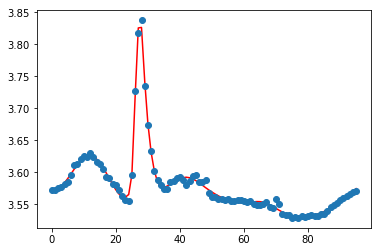

In [60]:
from scipy.interpolate import UnivariateSpline
df['hour_minute'] = df.date.map(lambda x: x.strftime('%H-%M'))
tmp = df.groupby('hour_minute').mean().reset_index()
spl = UnivariateSpline(tmp.index, tmp['travel_time_log'].values, s=0.002, k=3)
plt.plot(tmp.index, spl(tmp.index), 'r', tmp.index, tmp['travel_time_log'], 'o')
plt.show()

In [62]:
df[['link_ID', 'date', 'travel_time_log', 'travel_time', 'flow', 'speed', 'length', 'q']].to_csv(
    './data/HE_2013_M25LM326_6_10.csv', header=True, index=None, sep=';', mode='w')